# SSH

In [1]:
import xarray as xr
import numpy as np
import my_functions
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import cartopy.crs as ccrs
import statsmodels.api as sm
import os

In [2]:
## load data
os.chdir('/Users/marie-louisekorte/Documents/Uni Leipzig/Lisbon/')
SSH = xr.open_dataset('Data.nosync/SSH_weekly.nc')
ECCO2 = xr.open_dataset('Data.nosync/ECCO2_weekly.nc')
# mid-shelf coordinates
mid_shelf_lat = np.genfromtxt('Data.nosync/CoRTAD/lat_midshelf_CoRTAD.dat')[:,1]
mid_shelf_lon = np.genfromtxt('Data.nosync/CoRTAD/lon_midshelf_CoRTAD.dat')[:,1]

In [3]:
SSH = my_functions.add_week_and_month(SSH)
SSH = my_functions.add_mid_shelf(SSH, mid_shelf_lat, mid_shelf_lon)
ECCO2 = my_functions.add_week_and_month(ECCO2)
ECCO2 = my_functions.add_mid_shelf(ECCO2, mid_shelf_lat, mid_shelf_lon)

In [9]:
SSH_summer = my_functions.subset_summer(SSH)
ECCO2_summer = my_functions.subset_summer(ECCO2)

## SSH Index

In [4]:
SSH['UI'] = SSH.zos.where(SSH.lon == -10.5) - SSH.zos.where(SSH.mid_shelf).mean(dim = 'lon')
SSH.UI.attrs.update({'Name' : 'SSH upwelling index', 'Info' : 'SSH at 10.5°W - SSH at mid-shelf'})

In [5]:
SSH = my_functions.calc_meridional_mean(SSH, lon = -10.5)
SSH_summer = my_functions.subset_summer(SSH)

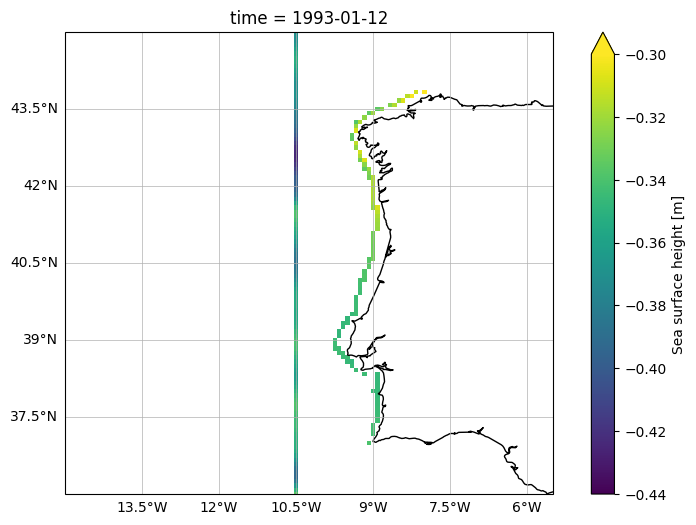

In [6]:
plt.figure(figsize=(10, 6))
    
# Set up the map 
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-15, -5.5, 45, 36])
gls = ax.gridlines(draw_labels=True, linewidth = 0.5)
gls.top_labels = False 
gls.right_labels = False
ax.coastlines()

pt = SSH.zos.where(SSH.lon == -10.5).isel(time = 0).plot.imshow(y = 'lat', x = 'lon', add_colorbar = False, vmin = -0.44, vmax = -0.3)
SSH.zos.where(SSH.mid_shelf).isel(time = 0).plot.imshow(y = 'lat', x = 'lon', vmin = -0.44, vmax = -0.3)

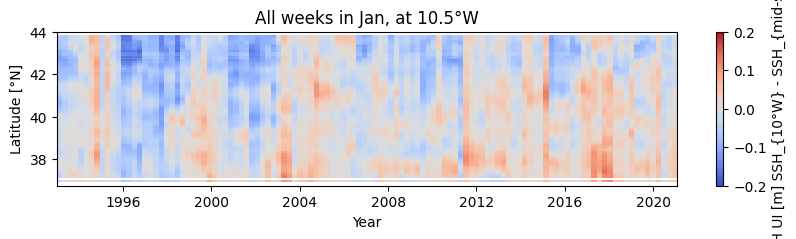

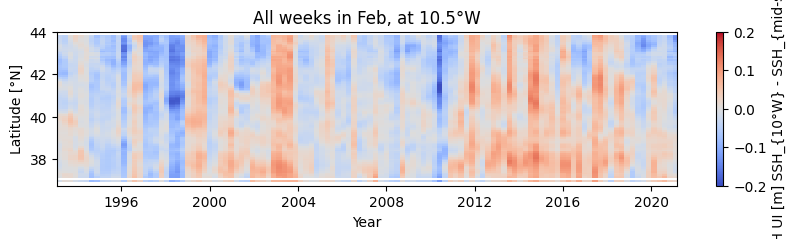

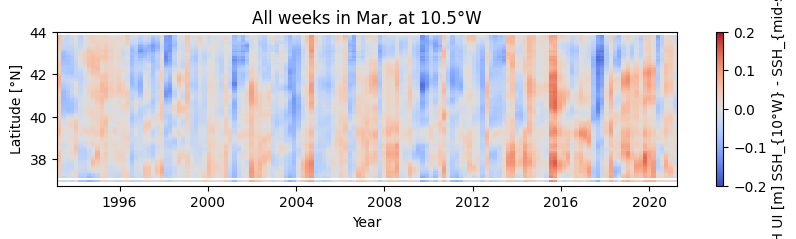

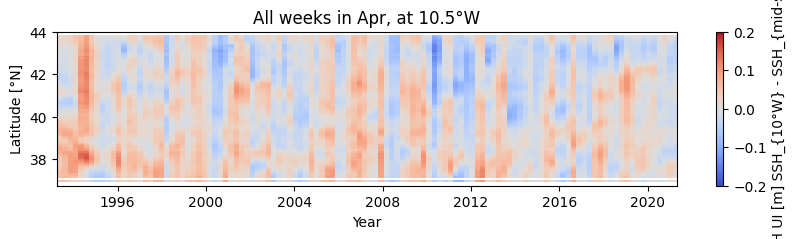

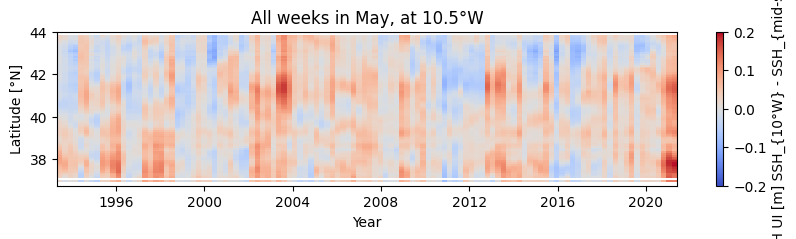

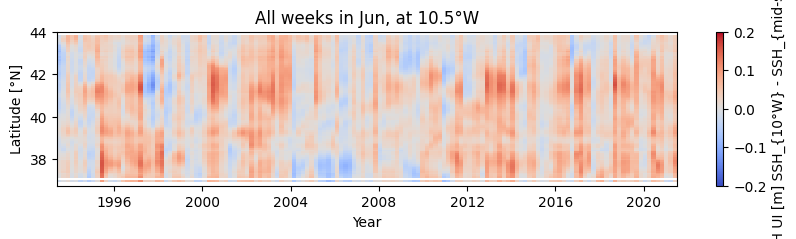

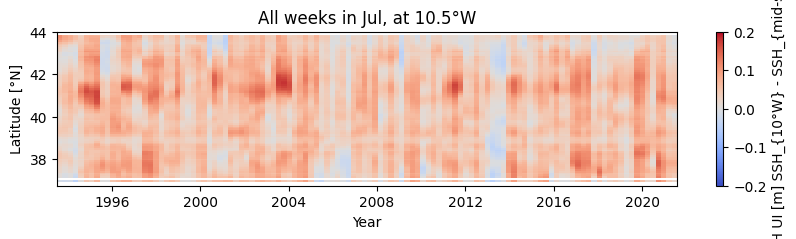

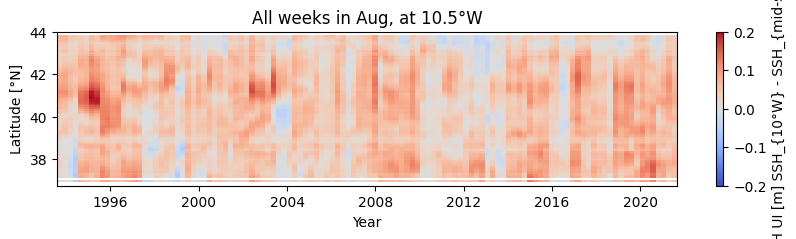

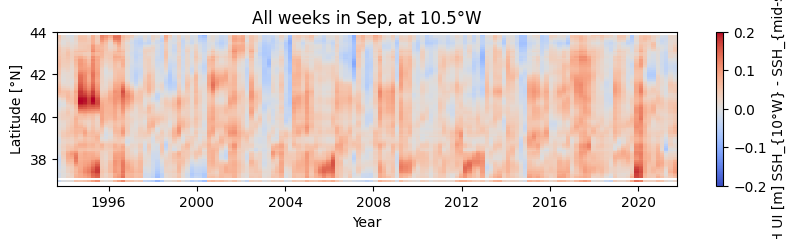

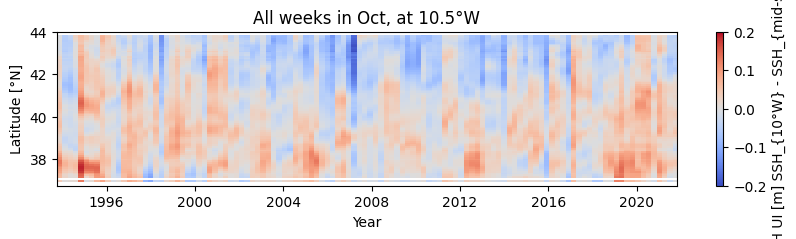

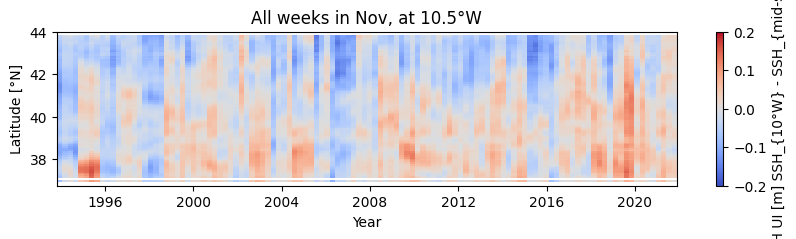

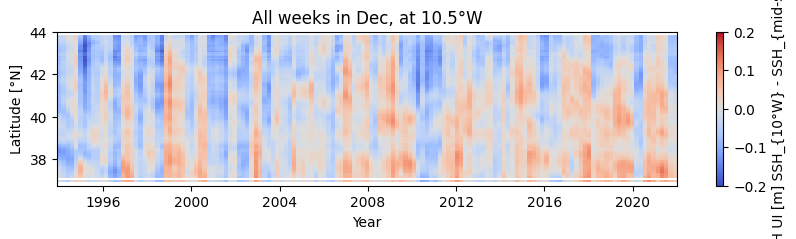

In [7]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for i in np.arange(0,12):
    #fig, [ax1, ax2] = plt.subplots(1, 2, figsize = (20, 2))
    fig = plt.figure(figsize = (10,2))
    cp = SSH.UI.sel(lon = -10.5).where((SSH.month == months[i]), drop = True).plot.imshow(y = 'lat', cmap = 'coolwarm', vmin = -0.2, vmax = 0.2, add_colorbar = False)
    plt.title(f'All weeks in {months[i]}, at 10.5°W')
    plt.xlabel('Year')
    plt.ylabel('Latitude [°N]')
    plt.ylim(36.75, 44)

    #plt.subplots_adjust(bottom=0.5, right=1.1, top=1.3)
    #fig.subplots_adjust(right = 0.5)
    #cbar_ax = fig.add_axes([0.51, 0.55, 0.01, 0.7])
    #fig.colorbar(cp2, cax=cbar_ax, label = 'Sea surface height [m]')
    plt.colorbar(cp, label = r'SSH UI [m] SSH_{10°W} - SSH_{mid-shelf}')

# I calculate the UI SSH by substratcting SSH at 10.5°W - SSH at mid-self -> i.e. the resulting UI SSH
# has positive values if SSH mid-shelf is lower than SSH at 10.5°W e.g.:
# -0.2 (10.5°W) - -0.4 (mid-shlef) = -0.2 + 0.4 = 0.2 UI SSH)

## SSH UI Trends

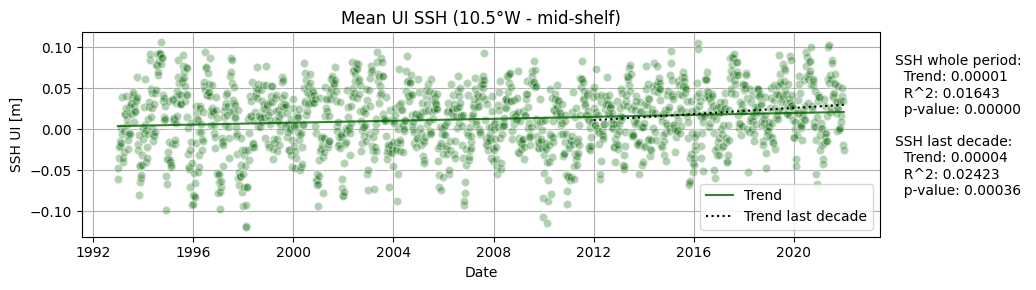

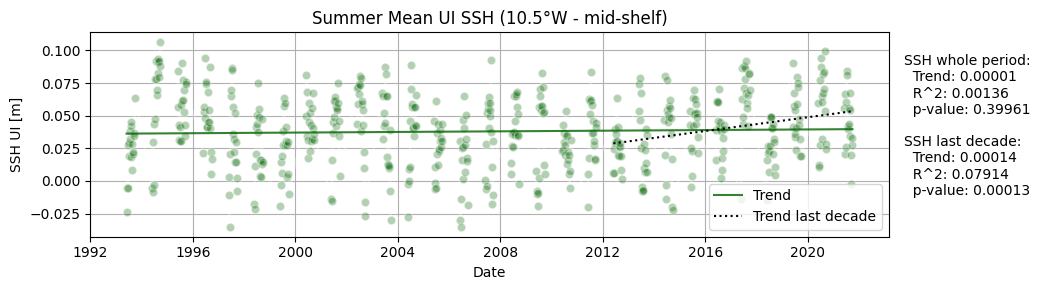

In [8]:
# get values for the trend line analysis
# check how I calculate the last 10 years!! I need to index correctly based on the data I have
for i in np.arange(0, 2):

    # variables
    if i == 0:
        x_dates = SSH.time
        y = SSH.UI_mean
        title = 'Mean UI SSH (10.5°W - mid-shelf)'
        color = 'darkgreen'
    if i == 1:
        x_dates = SSH_summer.time
        y = SSH_summer.UI_mean
        title = 'Summer Mean UI SSH (10.5°W - mid-shelf)'
    
    # start plot
    fig = plt.figure(figsize = (9, 3))

    # calculate a fit line
    x_num = dates.date2num(x_dates)
    trend = np.polyfit(x_num, y, 1)
    fit = np.poly1d(trend)
    
    # calculate fitline only for past decade
    # define last decades in years
    last_10 = x_dates.dt.isocalendar().year.max().values - 9 # minus nine years because the last year is already fully included 01/2021 - 12/2021

    # select last 10 years of data
    x_num_10 = np.delete(x_num, (np.where(x_dates.dt.isocalendar().year < last_10))) #x_num[-180:-1]
    y_10 = np.delete(y, (np.where(x_dates.dt.isocalendar().year < last_10))) #x_num[-180:-1]
    
    trend_10 = np.polyfit(x_num_10, y_10, 1)
    fit_10 = np.poly1d(trend_10)
    
    # general plot 
    plt.plot(x_dates, y, marker = 'o', markerfacecolor = color, alpha = 0.3, color = 'white')
    plt.xlabel('Date')
    plt.ylabel(r'SSH UI [m]')
    
    # get the input numbers for the fit line and convert the numbers back to dates
    x_fit = np.linspace(x_num.min(), x_num.max())
    plt.plot(dates.num2date(x_fit), fit(x_fit), color = color, linestyle = "-" , alpha = 0.8, label = 'Trend')
    
    # last 10 years
    x_fit_10 = np.linspace(x_num_10.min(), x_num_10.max())
    plt.plot(dates.num2date(x_fit_10), fit_10(x_fit_10), "k:", alpha = 1, label = 'Trend last decade') 
    
    plt.legend()
    plt.grid()
    plt.title(title)
    
    ## UI_SST whole period
    time = np.arange(0, len(x_dates))
    values = y.values
    time_with_const = sm.add_constant(time)
    model_full = sm.OLS(values, time_with_const).fit()   ## OLS -> ordinary least squares
    
    ## UI_SST last decace
    time = np.arange(0, len(x_num_10)) # this is only about length
    values = y_10.values
    time_with_const = sm.add_constant(time)
    model_10 = sm.OLS(values, time_with_const).fit()   ## OLS -> ordinary least squares
    
    plt.figtext(1, 0.28, f'SSH whole period: \n  Trend: {model_full.params[1]:.5f} \n  R^2: {model_full.rsquared:.5f} \n  p-value: {model_full.pvalues[1]:.5f} \n\nSSH last decade: \n  Trend: {model_10.params[1]:.5f} \n  R^2: {model_10.rsquared:.5f} \n  p-value: {model_10.pvalues[1]:.5f} \n')
    
    fig.tight_layout()
    # fig.savefig('../Iberian_Coast_Upwelling/Figures/UI_Trend_SST.png', dpi = 300, bbox_inches='tight')

## Plot monthly means

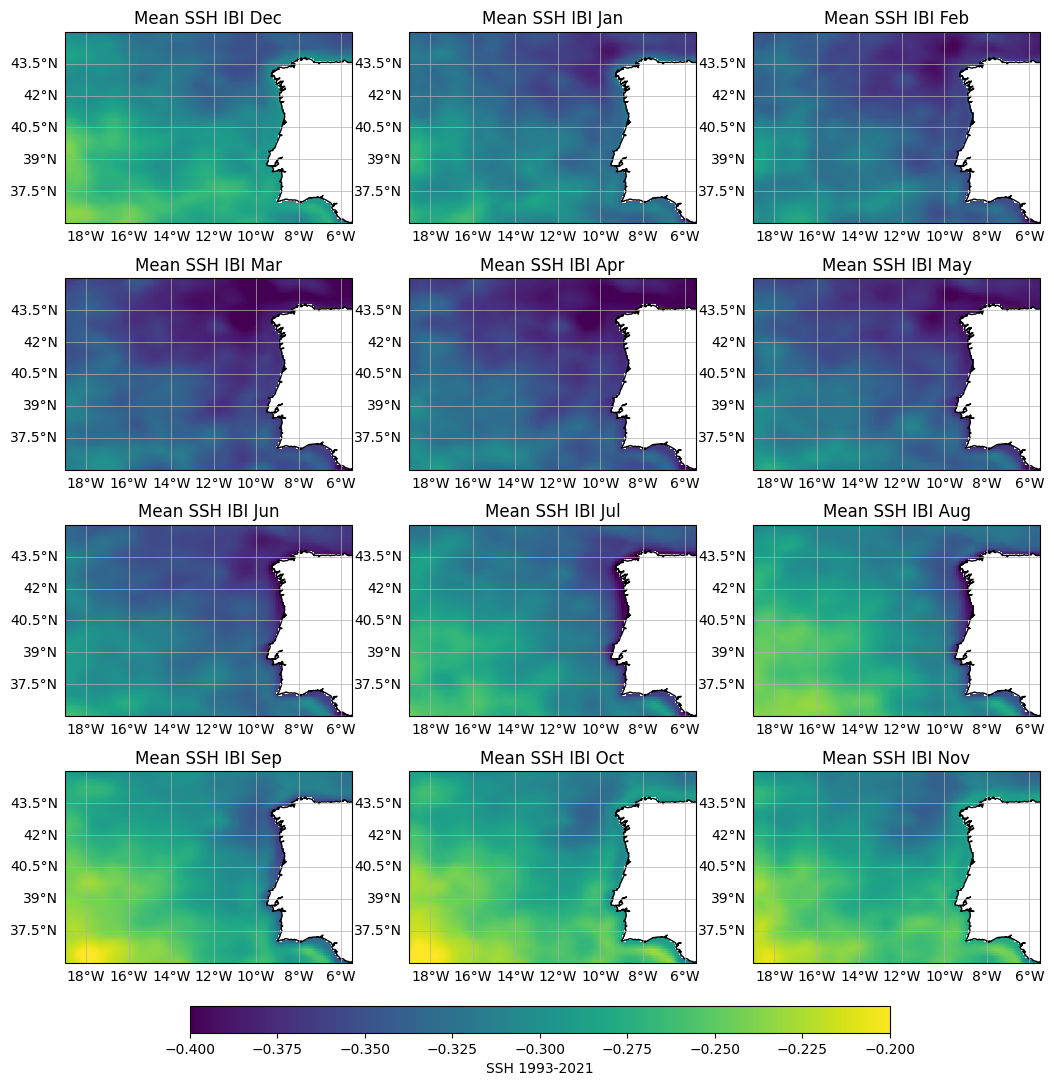

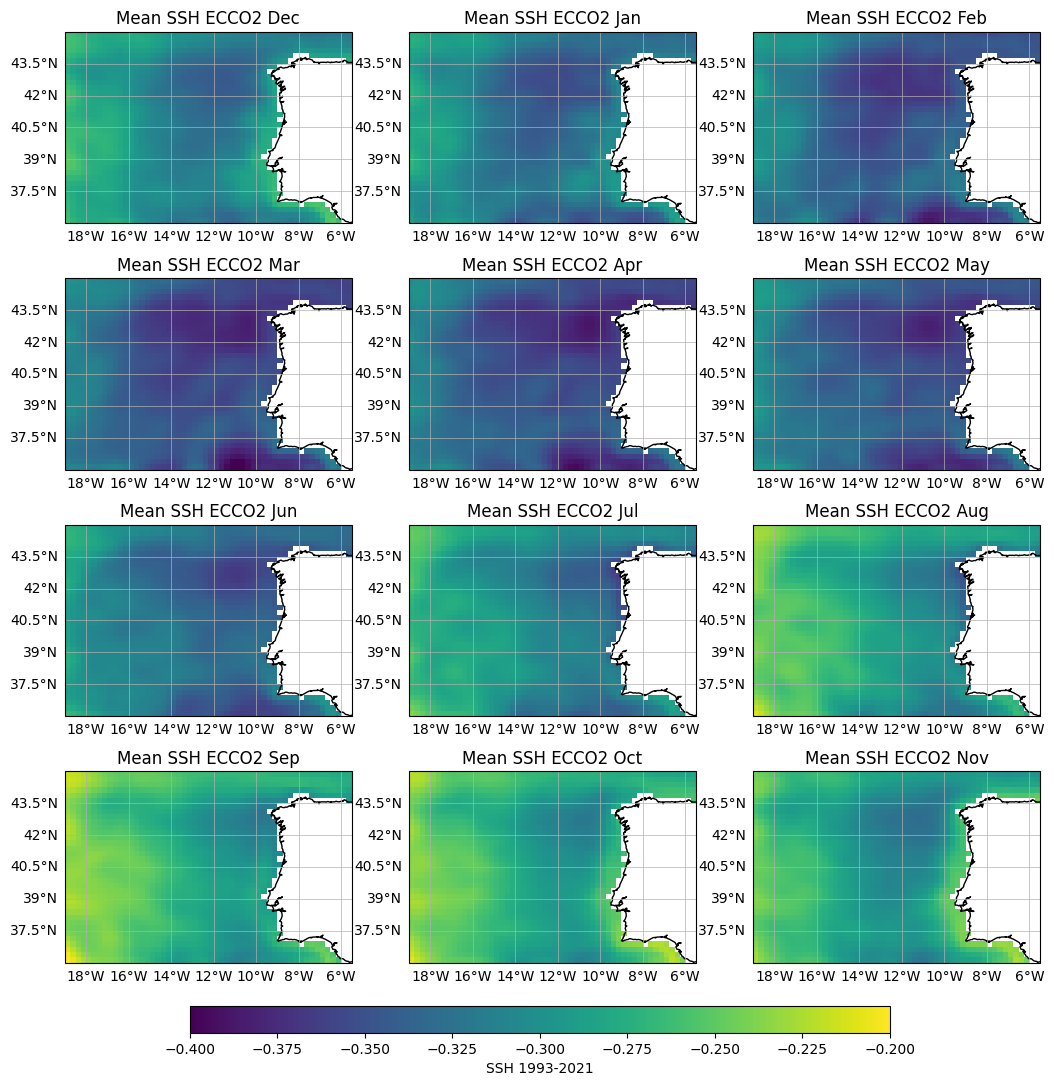

In [9]:
# IBI - Iberian Biscay Ireland 
xsize = 4 # is actually the number of rows
ysize = 3 # is the number of collumns

months = ['Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov']

for DS in ['IBI', 'ECCO2']:
    fig, axs = plt.subplots(xsize, ysize, figsize = (10, 9), subplot_kw={'projection': ccrs.PlateCarree()})
    i = 0
    for x in np.arange(0, xsize):
        for y in np.arange(0, ysize):
            
            ax = axs[x, y]
            
            ax.set_extent([-19, -5.5, 45, 36])
            ax.coastlines()
            gls = ax.gridlines(draw_labels=True, linewidth = 0.5)
            gls.top_labels = False 
            gls.right_labels = False
            
            if DS == 'IBI':
                cp = SSH.zos.where(SSH.month == months[i], drop = True).mean(dim = 'time').plot(ax = axs[x, y], transform = ccrs.PlateCarree(), add_colorbar = False, vmin = -0.4, vmax = -0.2, extend = 'both')
                ax.set_title(f'Mean SSH IBI {months[i]}')
            if DS == 'ECCO2':
                cp = ECCO2.SSH.where(ECCO2.month == months[i], drop = True).mean(dim = 'time').plot(ax = axs[x, y], transform = ccrs.PlateCarree(), add_colorbar = False, vmin = -0.4, vmax = -0.2, extend = 'both')
                ax.set_title(f'Mean SSH ECCO2 {months[i]}')
            
            ax.set_xlabel('Longitude [°E]')
            ax.set_ylabel('Latitude [°N]')
    
            i = i + 1
    
    # adjust spacing around subplots (because fig.tight_layout() doesn't work with the method I use to add the colorbar
    plt.subplots_adjust(bottom=0.5, right=1.1, top=1.3)
    
    fig.subplots_adjust(bottom = 0.25)
    cbar_ax = fig.add_axes([0.25, 0.18, 0.7, 0.03])
    fig.colorbar(cp, cax=cbar_ax, orientation = 'horizontal', label = 'SSH 1993-2021')

    if DS == 'IBI':
        fig.savefig('Iberian_Coast_Upwelling/Figures/SSH_IBI_monthly_mean.png', dpi = 300, bbox_inches = 'tight')
    if DS == 'ECCO2':
        fig.savefig('Iberian_Coast_Upwelling/Figures/SSH_ECCO2_monthly_mean.png', dpi = 300, bbox_inches = 'tight')

## Plot summer mean

In [12]:
## set dir where I want to save my figures
os.chdir('/Users/marie-louisekorte/Documents/Uni Leipzig/Lisbon/Iberian_Coast_Upwelling/Figures/Round II/')

In [13]:
## plot map

def plot_map(DS, title = 'Title', cmap = 'coolwarm', vmin = None, vmax = None, cbar_label = 'Label', add_contour = False, 
             save = False, save_fig_as = 'map'):
    plt.figure(figsize=(10, 6))
        
    # Set up the map 
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-19, -5.5, 45, 36])
    ax.coastlines()
    gls = ax.gridlines(draw_labels=True, linewidth = 0.5)
    gls.top_labels = False 
    gls.right_labels = False
      
    cp = DS.plot(add_colorbar = False, cmap = cmap, vmin = vmin, vmax = vmax, alpha = 0.8)
    plt.colorbar(cp, ax = ax, label = cbar_label, fraction = 0.046, pad = 0.01);

    if add_contour == True:
        clp = DS.plot.contour(colors = 'black', linewidths = 1, levels = np.arange(1010,1028, 0.25))
        plt.clabel(clp, fontsize = 7)
    
    plt.title(f'{title}')
    
    if save == True:
        plt.savefig(f'{save_fig_as}.png', dpi = 300, bbox_inches = 'tight')

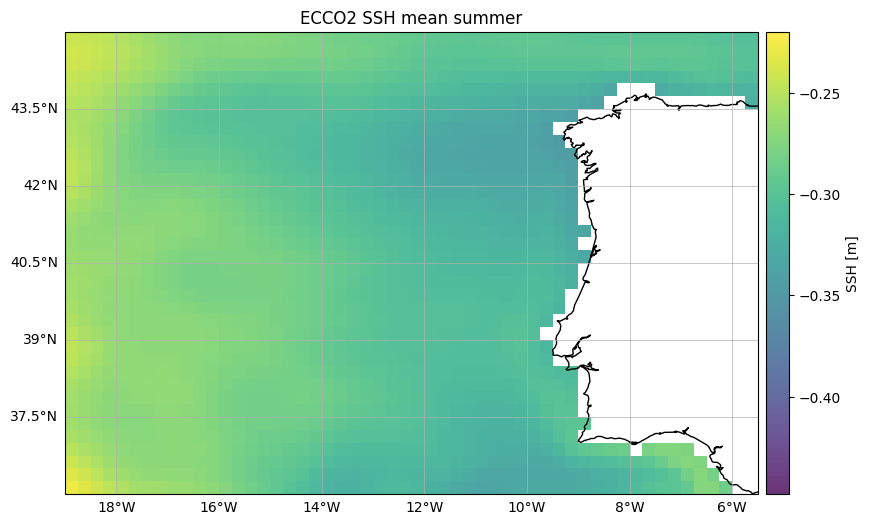

In [20]:
## mean summer SSH
plot_map(ECCO2_summer.SSH.mean(dim = 'time'), title = 'ECCO2 SSH mean summer',
        cmap = 'viridis', vmin = -0.448, vmax = -0.22, cbar_label = 'SSH [m]', 
         save = True, save_fig_as = 'Map_summer_mean_SSH_ECCO2')

## Plot weekly means

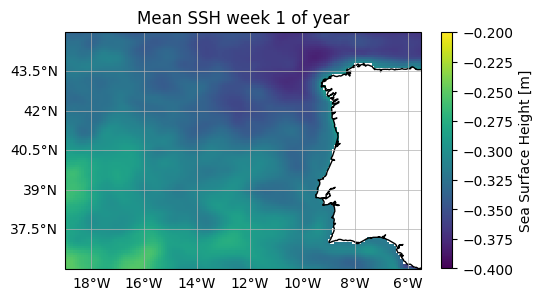

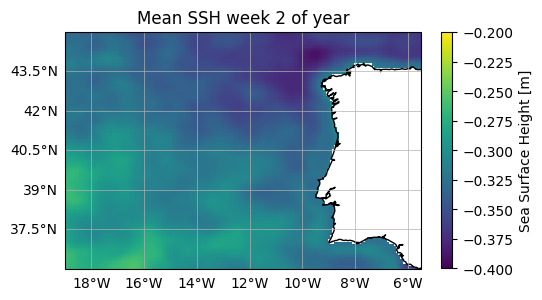

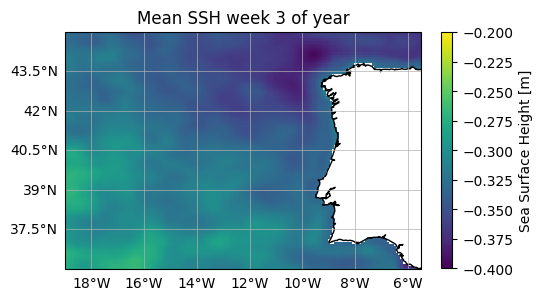

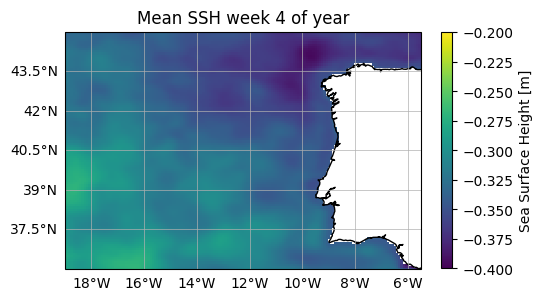

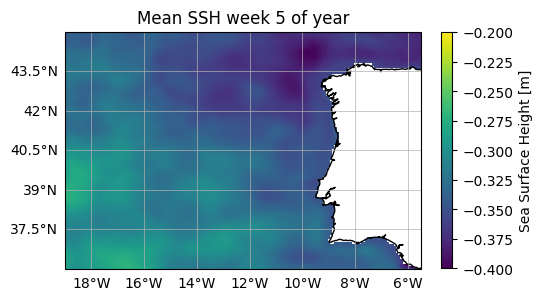

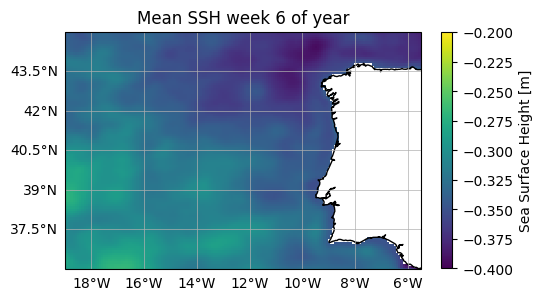

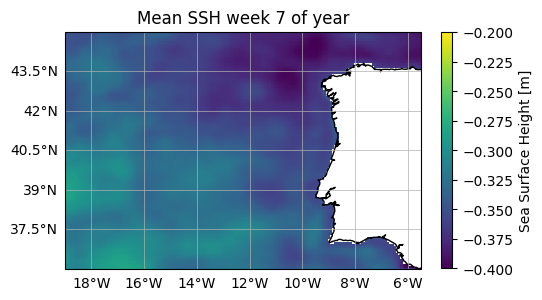

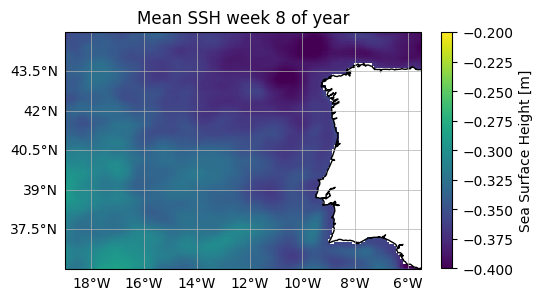

In [10]:
weeks = np.arange(1, 53)
i = 0

for week in weeks:
    fig = plt.figure(figsize = (5, 4))
    
    ax = plt.axes(projection=ccrs.PlateCarree())            
    ax.set_extent([-19, -5.5, 45, 36])
    ax.coastlines()
    gls = ax.gridlines(draw_labels=True, linewidth = 0.5)
    gls.top_labels = False 
    gls.right_labels = False
    
    
    cp = SSH.zos.where(SSH.week_of_year == week, drop = True).mean(dim = 'time').plot(transform = ccrs.PlateCarree(), add_colorbar = False, vmin = -0.4, vmax = -0.2, extend = 'both')
    plt.title(f'Mean SSH week {week} of year')
    plt.xlabel('Longitude [°E]')
    plt.ylabel('Latitude [°N]')
    plt.colorbar(cp, fraction = 0.0305, label = 'Sea Surface Height [m]')

    if week > 8:
        plt.close()
    
    fig.savefig(f'Iberian_Coast_Upwelling/Figures/SSH/SSH_weekly_mean/SSH_mean_week_{week:02d}_of_year.png', dpi = 300, bbox_inches = 'tight')

## Plot Anomaly

In [29]:
# first 20 years 1993-2011 (including)
SSH_ref = SSH.zos.sel(time = slice('1992-12-29', '2011-12-27')).mean(dim = 'time') # slice (0,992)
# ref last 10 years 2012-2021 (including)
SSH_decade = SSH.zos.sel(time = slice('2012-01-03', '2021-12-28')).mean(dim = 'time')  # slice (992, -1)

In [30]:
SSH_anomaly = SSH_ref - SSH_decade

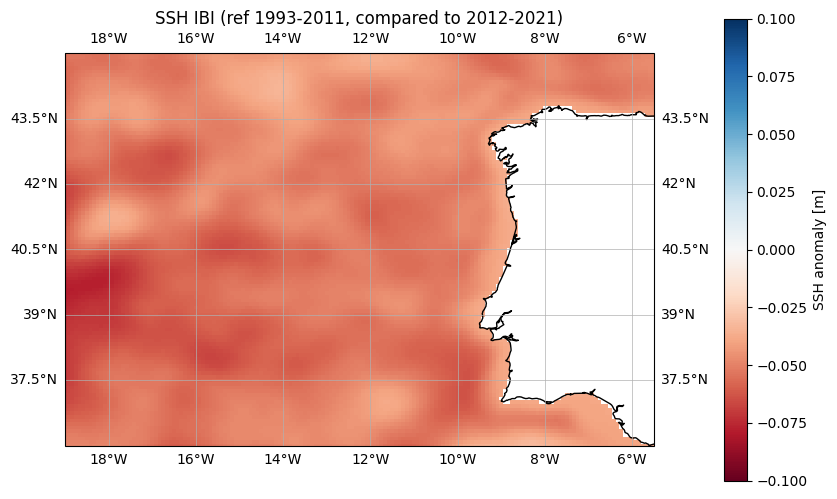

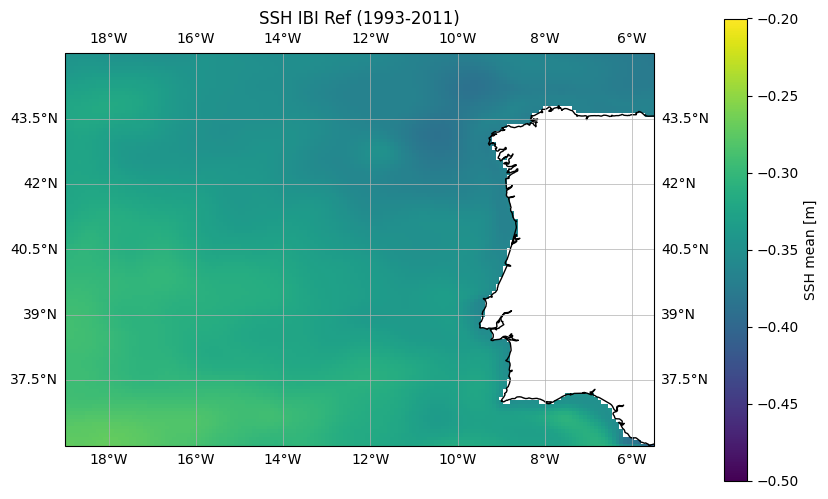

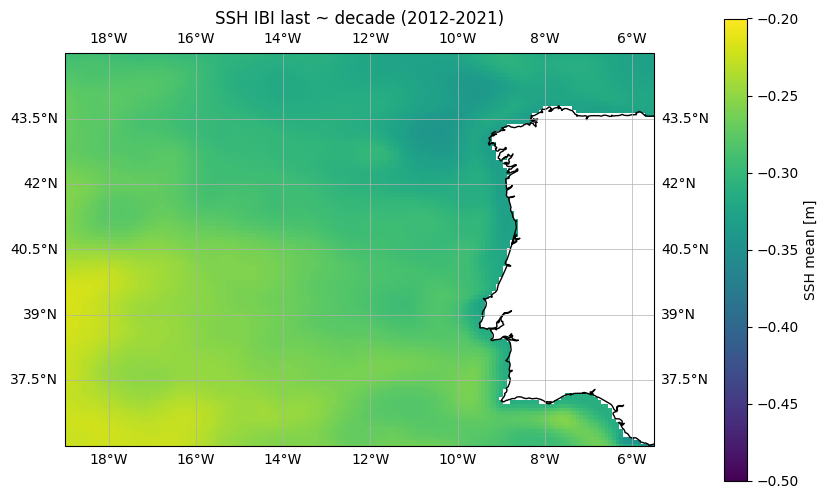

In [32]:
for i in np.arange(0,3):
    plt.figure(figsize=(10, 6))
        
    # Set up the map 
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-19, -5.5, 45, 36])
    ax.gridlines(draw_labels=True, linewidth = 0.5)
    ax.coastlines()
      
    # plot
    if i == 0:
        cp = SSH_anomaly.plot(add_colorbar = False, cmap = 'RdBu', vmin = -0.1, vmax = 0.1)
        plt.title(f'SSH IBI (ref 1993-2011, compared to 2012-2021)')
        plt.colorbar(cp, ax = ax, label = r'SSH anomaly [m]', pad = 0.09);
        #plt.savefig('Iberian_Coast_Upwelling/Figures/SSH_anomaly.png', dpi = 300, bbox_inches = 'tight')
    if i == 1:
        cp = SSH_ref.plot(add_colorbar = False, cmap = 'viridis', vmin = -0.5, vmax = -0.2)
        plt.title(f'SSH IBI Ref (1993-2011)')
        plt.colorbar(cp, ax = ax, label = r'SSH mean [m]', pad = 0.09);
        #plt.savefig('Iberian_Coast_Upwelling/Figures/SSH_ref_period.png', dpi = 300, bbox_inches = 'tight')
    if i == 2:
        cp = SSH_decade.plot(add_colorbar = False, cmap = 'viridis', vmin = -0.5, vmax = -0.2)
        plt.title(f'SSH IBI last ~ decade (2012-2021)')
        plt.colorbar(cp, ax = ax, label = r'SSH mean [m]', pad = 0.09);
        #plt.savefig('Iberian_Coast_Upwelling/Figures/SSH_last_decade.png', dpi = 300, bbox_inches = 'tight')
    
    

In [14]:
# first 20 years 1993-2012 (including)
ECCO2_ref = ECCO2.SSH.sel(time = slice('1992-12-29', '2012-12-31')).mean(dim = 'time') 
# ref last 10 years 2013-2022 (including)
ECCO2_decade = ECCO2.SSH.sel(time = slice('2013-01-01', '2022-12-31')).mean(dim = 'time')  

In [15]:
ECCO2_anomaly = ECCO2_ref - ECCO2_decade

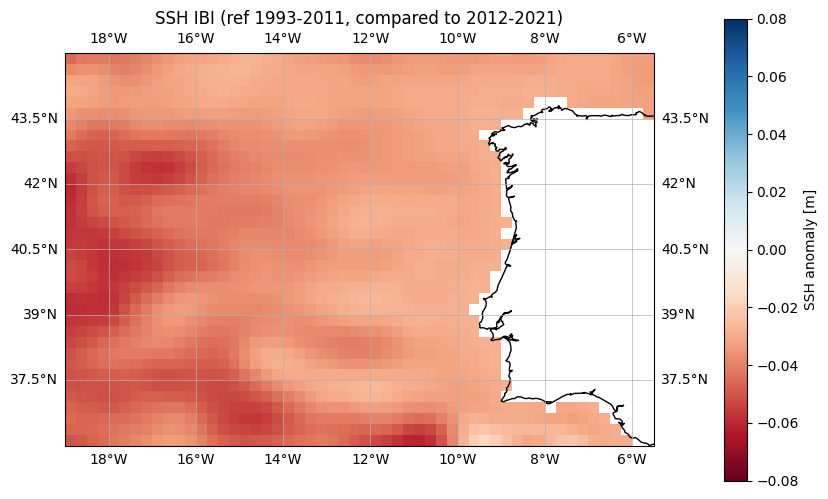

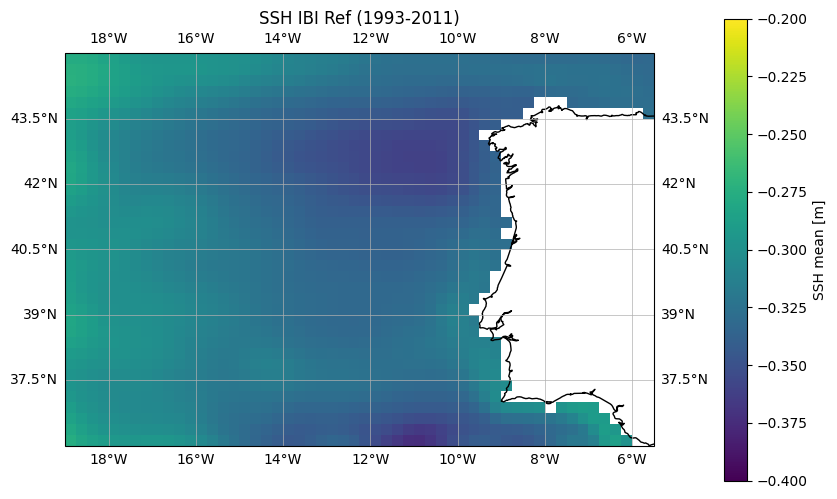

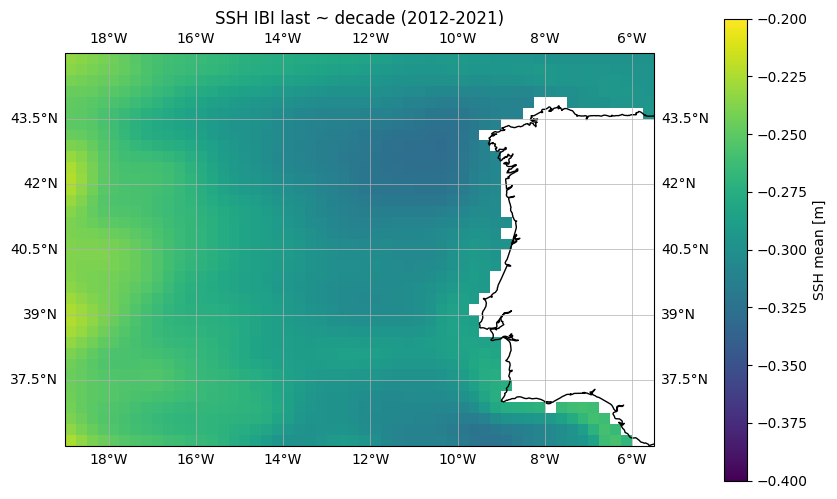

In [34]:
for i in np.arange(0,3):
    plt.figure(figsize=(10, 6))
        
    # Set up the map 
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-19, -5.5, 45, 36])
    ax.gridlines(draw_labels=True, linewidth = 0.5)
    ax.coastlines()
      
    # plot
    if i == 0:
        cp = ECCO2_anomaly.plot(add_colorbar = False, cmap = 'RdBu', vmin = -0.08, vmax = 0.08)
        plt.title(f'SSH IBI (ref 1993-2011, compared to 2012-2021)')
        plt.colorbar(cp, ax = ax, label = r'SSH anomaly [m]', pad = 0.09);
        #plt.savefig('Iberian_Coast_Upwelling/Figures/SSH_anomaly.png', dpi = 300, bbox_inches = 'tight')
    if i == 1:
        cp = ECCO2_ref.plot(add_colorbar = False, cmap = 'viridis', vmin = -0.4, vmax = -0.2)
        plt.title(f'SSH IBI Ref (1993-2011)')
        plt.colorbar(cp, ax = ax, label = r'SSH mean [m]', pad = 0.09);
        #plt.savefig('Iberian_Coast_Upwelling/Figures/SSH_ref_period.png', dpi = 300, bbox_inches = 'tight')
    if i == 2:
        cp = ECCO2_decade.plot(add_colorbar = False, cmap = 'viridis', vmin = -0.4, vmax = -0.2)
        plt.title(f'SSH IBI last ~ decade (2012-2021)')
        plt.colorbar(cp, ax = ax, label = r'SSH mean [m]', pad = 0.09);
        #plt.savefig('Iberian_Coast_Upwelling/Figures/SSH_last_decade.png', dpi = 300, bbox_inches = 'tight')
    
    

## Plot SSH along shore

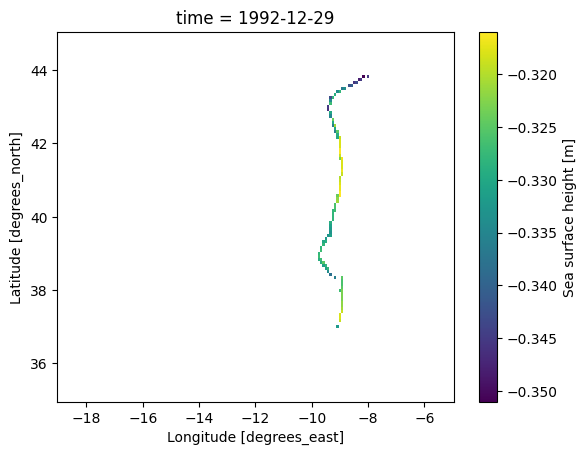

In [17]:
SSH.zos.isel(time = 0).where(SSH.mid_shelf).plot()

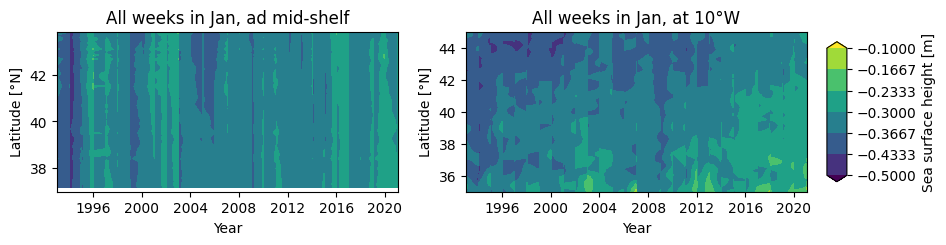

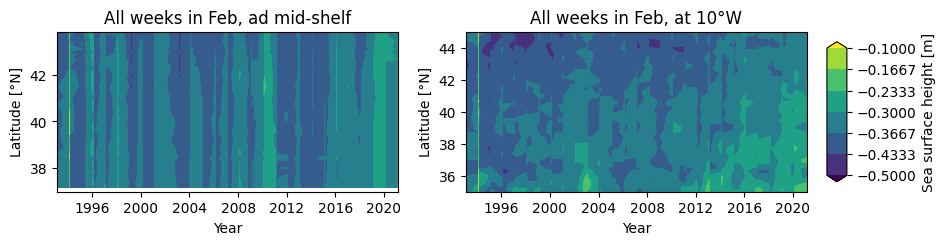

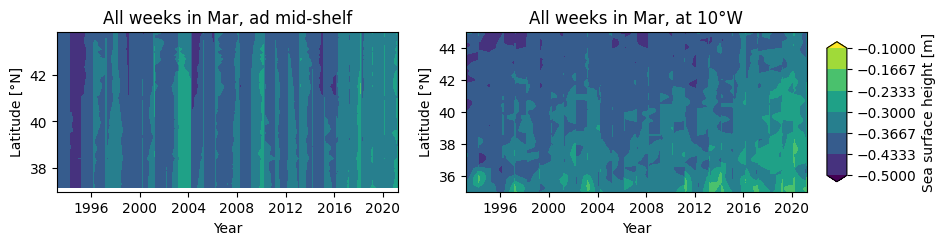

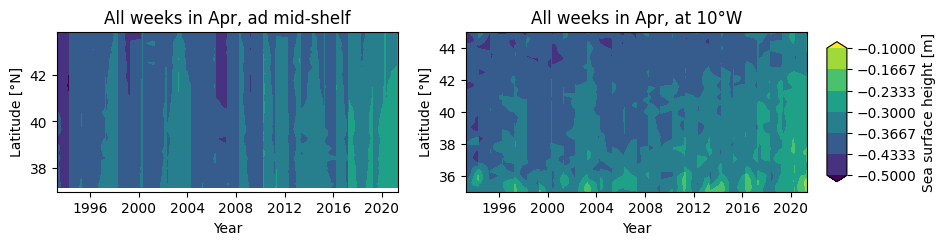

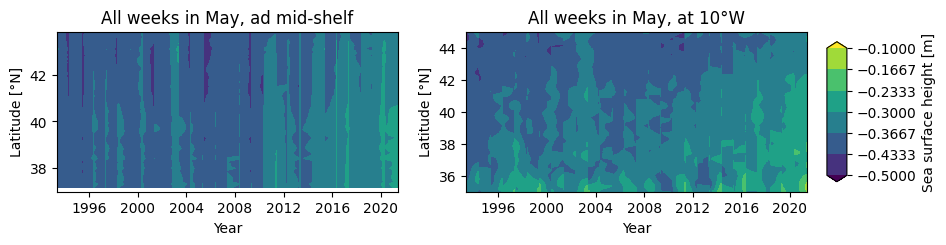

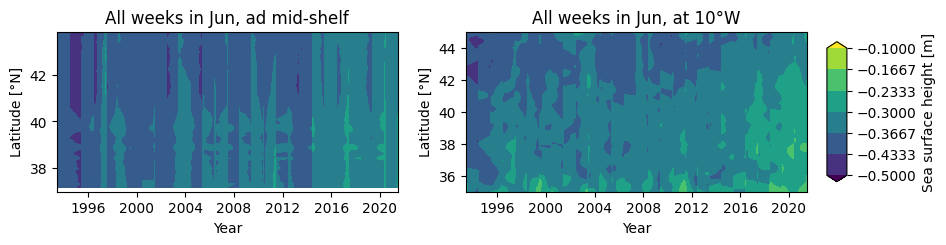

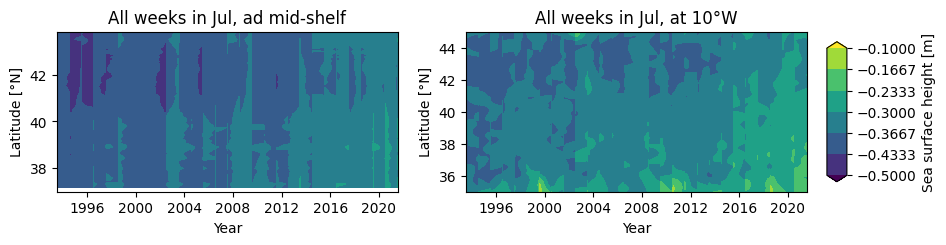

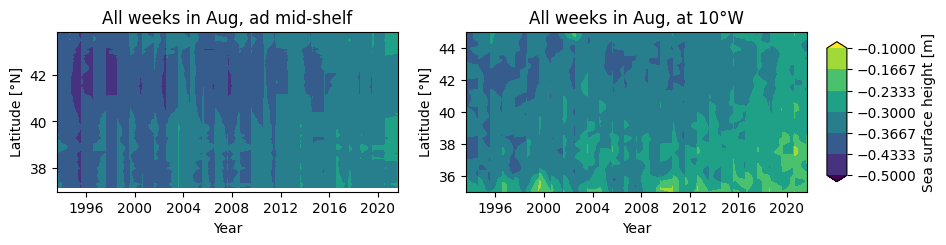

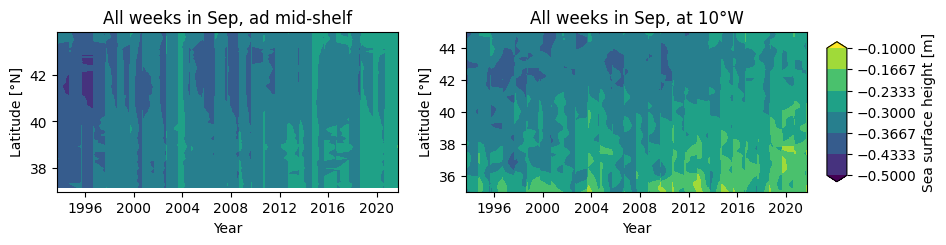

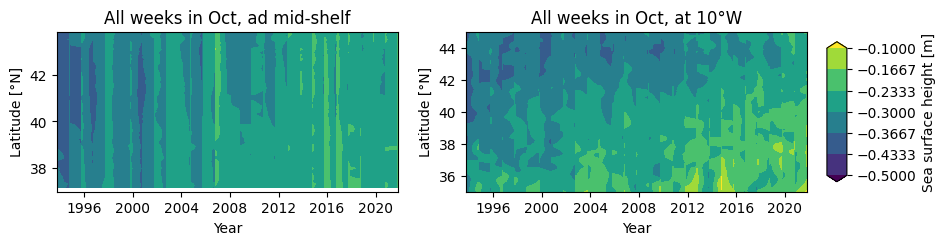

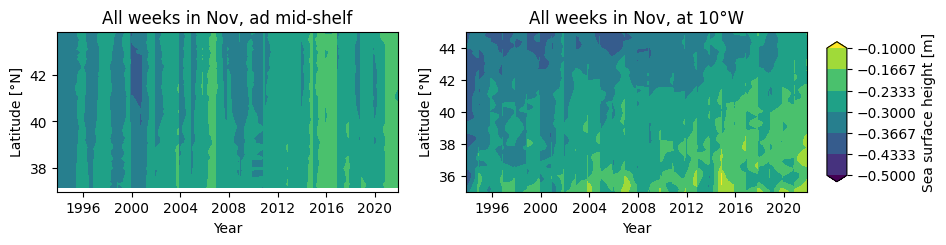

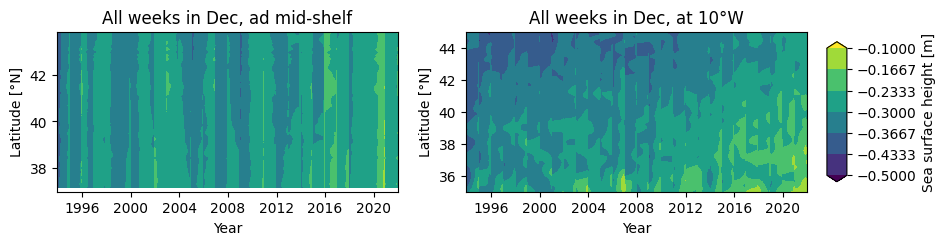

In [18]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for i in np.arange(0,12):
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize = (20, 2))
    cp1 = SSH.zos.where((SSH.month == months[i]) & (SSH.mid_shelf == True), drop = True).mean(dim = 'lon').plot.contourf(ax = ax1, y = 'lat', vmin = -0.5, vmax = -0.1, extend = 'both', add_colorbar = False)
    ax1.set_title(f'All weeks in {months[i]}, ad mid-shelf')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Latitude [°N]')

    cp2 = SSH.zos.sel(lon = -10).where((SSH.month == months[i]), drop = True).plot.contourf(ax = ax2, y = 'lat', vmin = -0.5, vmax = -0.1, extend = 'both', add_colorbar = False)
    ax2.set_title(f'All weeks in {months[i]}, at 10°W')
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Latitude [°N]')

    plt.subplots_adjust(bottom=0.5, right=1.1, top=1.3)
    fig.subplots_adjust(right = 0.5)
    cbar_ax = fig.add_axes([0.51, 0.55, 0.01, 0.7])
    fig.colorbar(cp2, cax=cbar_ax, label = 'Sea surface height [m]')

    fig.savefig(f'Iberian_Coast_Upwelling/Figures/SSH/SSH_contour_{i+1:02d}.png', dpi = 300, bbox_inches = 'tight')


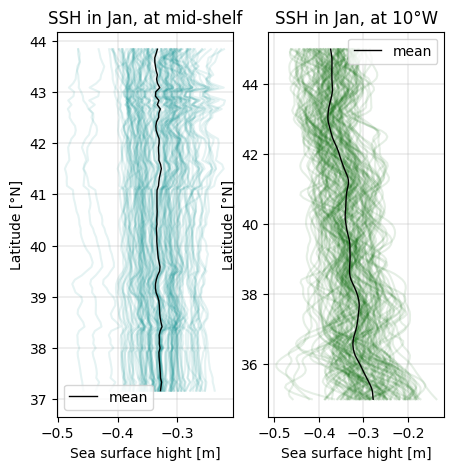

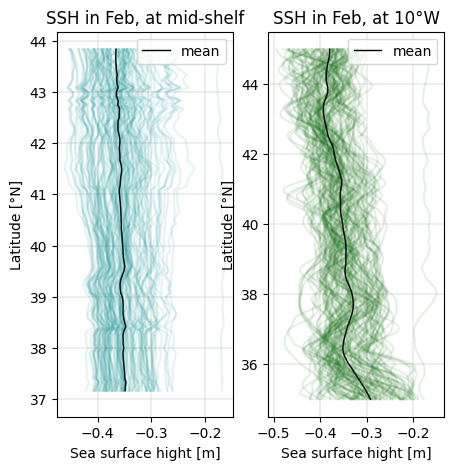

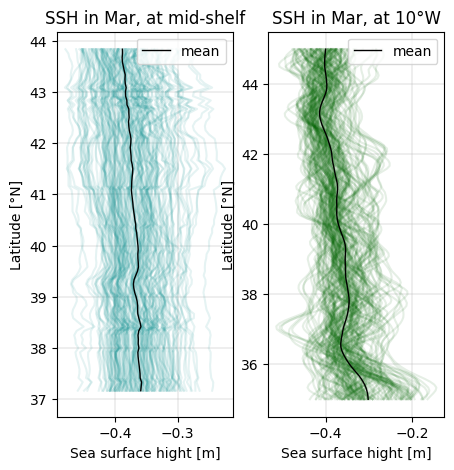

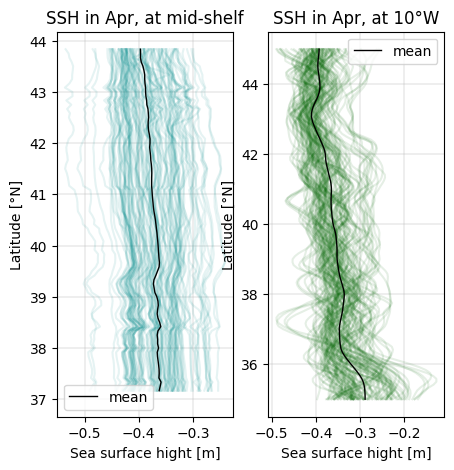

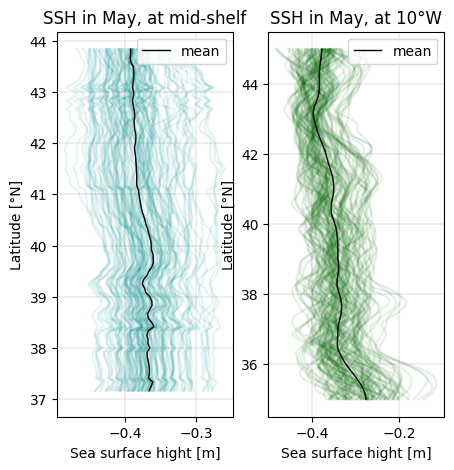

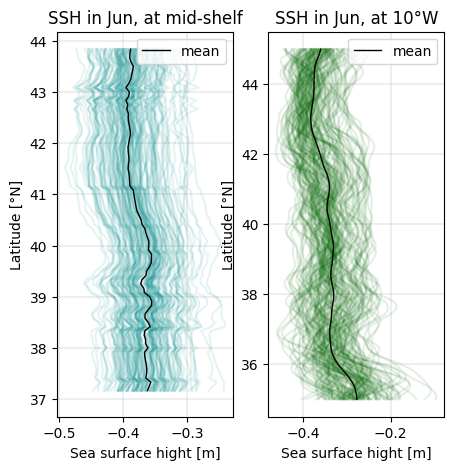

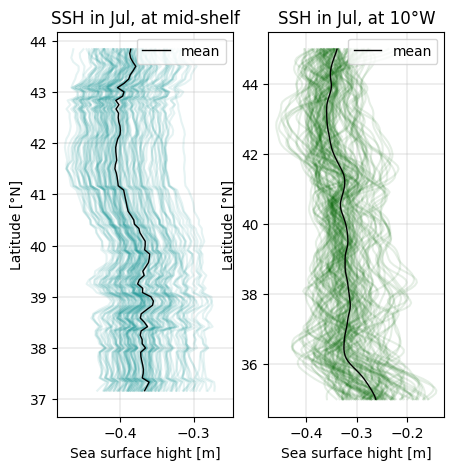

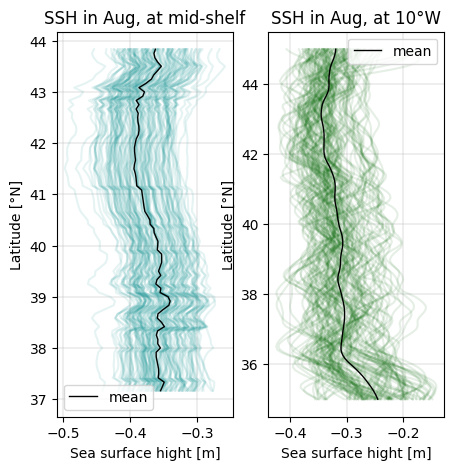

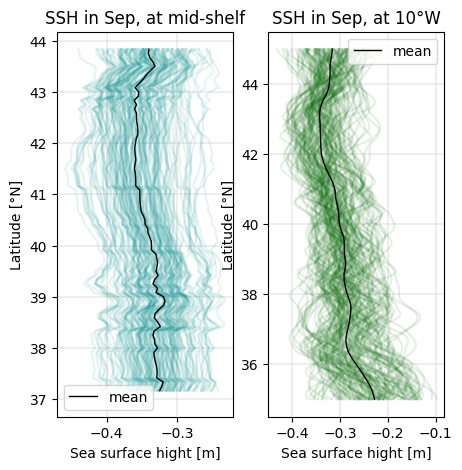

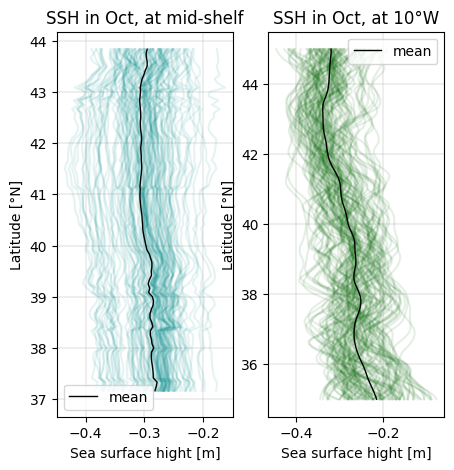

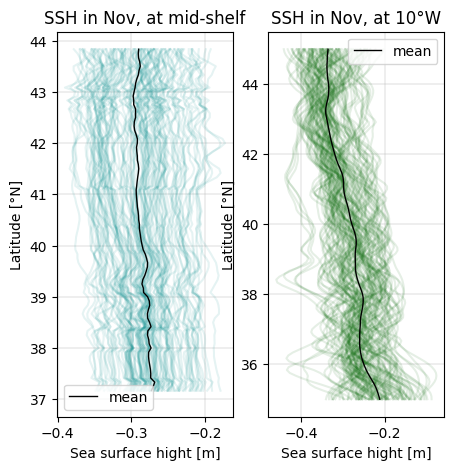

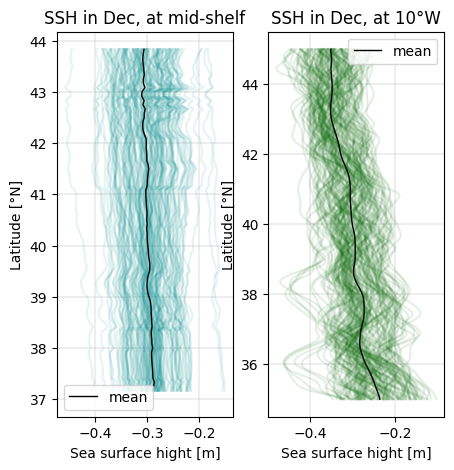

In [26]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for i in np.arange(0,12):
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize = (5, 5))
    ax1.plot(SSH.zos.where((SSH.month == months[i]) & (SSH.mid_shelf == True), drop = True).mean(dim = 'lon').T, SSH.where(SSH.mid_shelf, drop = True).lat, color = 'darkcyan', alpha = 0.1);
    ax1.plot(SSH.zos.where((SSH.month == months[i]) & (SSH.mid_shelf == True), drop = True).mean(dim = 'lon').mean(dim = 'time').T, SSH.where(SSH.mid_shelf, drop = True).lat, 'k', linewidth = 1, label = 'mean');
    ax1.set_title(f'SSH in {months[i]}, at mid-shelf')
    ax1.set_xlabel('Sea surface hight [m]')
    ax1.set_ylabel('Latitude [°N]')
    ax1.grid(linewidth = 0.3)
    ax1.legend()

    ax2.plot(SSH.zos.sel(lon = -10.5).where((SSH.month == months[i]), drop = True).T, SSH.lat, color = 'darkgreen', alpha = 0.1);
    ax2.plot(SSH.zos.sel(lon = -10.5).where((SSH.month == months[i]), drop = True).mean(dim = 'time').T, SSH.lat, 'k', linewidth = 1, label = 'mean');
    ax2.set_title(f'SSH in {months[i]}, at 10°W')
    ax2.set_xlabel('Sea surface hight [m]')
    ax2.set_ylabel('Latitude [°N]')
    ax2.grid(linewidth = 0.3)
    ax2.legend()

    #fig.savefig(f'Iberian_Coast_Upwelling/Figures/SSH/SSH_{i+1:02d}.png', dpi = 300, bbox_inches = 'tight')
    